In [1]:
# imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from pgmpy.estimators import HillClimbSearch, PC
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.metrics import log_likelihood_score
from pgmpy.models import BayesianNetwork

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
%matplotlib inline
plt.style.use('dark_background')

# Data set

Contains data on demographics and an target feature which indicates if the person earns more than $50k a year.

In [3]:
df = pd.read_csv(
    "https://www.openml.org/data/get_csv/1595261/phpMawTba", na_values=' ?'
)

## Missing values

In this dataset, missing values are identified with the question mark (with a preceding space), ` ?`.

Check the non-null counts to confirm that some values have been identified as `NA` (Not Available).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  class           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
df.isna().sum() # equivalently

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64

Even in Bayesian Networks **can** handle missing values (note the EM algorithm, for example), in this case imputation of missing values will be performed in order to simplify learning both _structure_ and _parameters_.

Instead of performing a rather simplistic imputation based only on the present (non-null) values of the specific variable, a more realistic approach would be to use the **whole _data-points_** to try to estimate missing values. 

Nevertheless, bear in mind that this kind of imputation, which usually entails computing an average, is only feasible for numeric variables. Sadly, not available values in the data set all belong to categorical variables. Imputation for discrete values is not as well support and so we resort to a simplified imputation. Namely, the most frequent value of each variable is used as the imputation value. According to scikit-learn's documentation:

> If there is more than one such value, only the smallest is returned.

In [6]:
mask = df.dtypes == object
df.loc[:, mask].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       46043 non-null  object
 1   education       48842 non-null  object
 2   marital-status  48842 non-null  object
 3   occupation      46033 non-null  object
 4   relationship    48842 non-null  object
 5   race            48842 non-null  object
 6   sex             48842 non-null  object
 7   native-country  47985 non-null  object
 8   class           48842 non-null  object
dtypes: object(9)
memory usage: 3.4+ MB


In [7]:
# not neccesary to explictly specify NA values
# missing_values='?'
imp = SimpleImputer(strategy='most_frequent')
df.loc[:, mask] = imp.fit_transform(df.loc[:, mask]) # copy=False is invalid

The total number of missing values now is

In [8]:
df.isna().sum().sum()

0

## Continuous features

Bayesian networks can handle both discrete and continuous variables. However, we will focus on discrete Bayesian networks.

Therefore, continuous features will need to be discretized. Continuous features are usually identified with numerical features. But that is not always the case. The `education-num` variable is categorial, even though it is codified with numbers.

In [9]:
len(df['education-num'].value_counts()) # number of different values

16

In [10]:
mask = df.dtypes == np.int64
mask[4] = False # education-num index
df.loc[:, mask]

,age,fnlwgt,capital-gain,capital-loss,hours-per-week
0,25,226802,0,0,40
1,38,89814,0,0,50
2,28,336951,0,0,40
3,44,160323,7688,0,40
4,18,103497,0,0,30
...,...,...,...,...,...
48837,27,257302,0,0,38
48838,40,154374,0,0,40
48839,58,151910,0,0,40
48840,22,201490,0,0,20


Using `scikit-learn`, there basically two options to discretize all continuous variables. 
One option is to create an indivual transformation for each.
```
bins = [0, 1, 13, 20, 60, np.inf]
labels = ['infant', 'kid', 'teen', 'adult', 'senior citizen']
age_tf = FunctionTransformer(
    pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
)
age_tf.fit_transform(df['age'])
```
But there is an alternative that consists of making use of `scikit-learn`'s `KBinsDiscretizer`.
One of the advantages of this technique is that the bins can be selected according to various strategies. The chosen method performs clustering for each variable (1-D) in order to group the instances.

**to do**: https://pgmpy.org/factors/discretize.html

In [11]:
# n_bins=5 (default)
ct = ColumnTransformer([
    ('age',  KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans'), [0]),
    ('fnlwgt',         KBinsDiscretizer(encode='ordinal', strategy='kmeans'), [1]),
    ('capital-gain',   KBinsDiscretizer(encode='ordinal', strategy='kmeans'), [2]),
    ('capital-loss',   KBinsDiscretizer(encode='ordinal', strategy='kmeans'), [3]),
    ('hours-per-week', KBinsDiscretizer(encode='ordinal', strategy='kmeans'), [4])
])
ct.fit_transform(df.loc[:, mask])

array([[0., 2., 0., 0., 1.],
       [1., 0., 0., 0., 2.],
       [0., 3., 0., 0., 1.],
       ...,
       [2., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [2., 2., 2., 0., 1.]])

In [12]:
df.loc[:, mask] = ct.fit_transform(df.loc[:, mask])
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,0.0,Private,2.0,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,1.0,United-States,<=50K
1,1.0,Private,0.0,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,2.0,United-States,<=50K
2,0.0,Local-gov,3.0,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,1.0,United-States,>50K
3,1.0,Private,1.0,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,1.0,0.0,1.0,United-States,>50K
4,0.0,Private,0.0,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0.0,0.0,1.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.0,Private,2.0,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,1.0,United-States,<=50K
48838,1.0,Private,1.0,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,1.0,United-States,>50K
48839,2.0,Private,1.0,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,1.0,United-States,<=50K
48840,0.0,Private,1.0,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,0.0,United-States,<=50K


# Learning

With `pgmpy`.

But first, let's split the data set into two training and validation sets.

In [13]:
df.shape

(48842, 15)

In [14]:
train, valid = train_test_split(df, train_size=2/3, random_state=0)

print(train.shape)
print(valid.shape)

(32561, 15)
(16281, 15)


## Structure learning

From the data, estimate dependencies and, therefore, the more appropiate DAG.

In this notebook, two learning methods are explored.

In [15]:
dags = []

### Score-based structure learning

The naive approach is an exhaustive search.
Because the search space of DAGs is super-exponential, once more than a few nodes are involved, one needs to switch to heuristic search. `HillClimbSearch` implements a greedy local search that starts from the DAG `start` (which by default is a disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score. The search terminates once a local maximum is found.

In [16]:
hc = HillClimbSearch(train)

A non-exhaustive list of hyperparameters for the model is:

- `scoring_method`: the score to be optimized during structure estimation.
- `tabu_list`: Set the length (`n`) of the tabu list. It effectively enforces a wider exploration of the search space. The list keeps track of the last `n` modfications; those are then not allowed to be reversed, regardless of the score.
- `white_list`: restrict the search to a particular subset of the edges/nodes.
- `black_list`: exclude certain edges/nodes from the search.
- `max_indegree`: allows to restrict the maximum number of parents for each node.

In [17]:
black_list = ['fnlwgt', 'sex', 'race', 'native-country', 'relationship']

hc_def = hc.estimate() # default
hc_bde = hc.estimate(scoring_method='bdeuscore')
hc_tl = hc.estimate(tabu_length=0)
hc_mi = hc.estimate(max_indegree=2)
hc_bl = hc.estimate(black_list=black_list)

dags.append(hc_def)
dags.append(hc_bde)
dags.append(hc_tl)
dags.append(hc_mi)
dags.append(hc_bl)

print("  0%|          | ne/maximum [ ...time_stats... ]")
print("--> if 'ne' is the number of edges for the model")

  0%|          | 29/1000000 [00:20<192:47:03,  1.44it/s]

  0%|          | ne/maximum [ ...time_stats... ]
--> if 'ne' is the number of edges for the model


### Constraint-based structure learning

A different, but quite straightforward approach to build a DAG from data is to identify independencies in the data set using hypothesis tests (for example, $\chi^2$ tests) and then construct DAG (pattern) according to those identified independencies.

This procedure can potentially define structures that are not representable as DAGs (e.g., a cycle) and, hence, as BNs.

In [18]:
pc = PC(train)

A non-exhaustive list of hyperparameters for the model is:
- `variant`: the variant of PC algorithm to run.
- `ci_test`: the statistical test to assess conditional independece.
- `max_cond_vars`: the maximum number of conditional variables. It relates to the number of parents in the network.
- `significance_level`: threshold for the $p$-value that decides independence.

In [19]:
# pc_def = pc.estimate() # default
pc_ori = pc.estimate(variant='orig', max_cond_vars=1)
pc_mcv = pc.estimate(max_cond_vars=1)
pc_sl = pc.estimate(max_cond_vars=1, significance_level=0.05)

print("Working for n conditional variables: n: 100%|██████████| n/m [ ...time_stats... ]\n")

# models.append(pc_def)

# check if there is valid structure first
if nx.is_directed_acyclic_graph(pc_ori):
    dags.append(pc_ori)
else:
    print("Not a DAG. Not able to construct a network.")
    print("<- parameters (variant='orig', max_cond_vars=1)")

if nx.is_directed_acyclic_graph(pc_mcv):
    dags.append(pc_mcv)
else:
    print("Not a DAG. Not able to construct a network.")
    print("<- parameter (max_cond_vars=1)")

if nx.is_directed_acyclic_graph(pc_sl):
    dags.append(pc_sl)
else:
    print("Not a DAG. Not able to construct a network.")
    print("<- parameters (max_cond_vars=1, significance_level=0.05)")

Working for n conditional variables: 1: 100%|██████████| 1/1 [01:26<00:00, 86.40s/it]
C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pgmpy\base\DAG.py:1187: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(
Working for n conditional variables: 1: 100%|██████████| 1/1 [01:18<00:00, 78.81s/it]

Working for n conditional variables: n: 100%|██████████| n/m [ ...time_stats... ]

Not a DAG. Not able to construct a network.
<- parameters (variant='orig', max_cond_vars=1)
Not a DAG. Not able to construct a network.
<- parameter (max_cond_vars=1)
Not a DAG. Not able to construct a network.
<- parameters (max_cond_vars=1, significance_level=0.05)


## Parameter learning

Once the structure of the network is available, the independent paramaters that define the network can be estimated. This is, probabilities for the conditional probability distributions (CPDs).

Even if the training set is quite large, because it also has a lot of variables, we will compare the probability estimates obtained with and without considering a prior distribution.

In [20]:
# the network can be defined just by passing a list of edges
models = [BayesianNetwork(dag.edges) for dag in dags]

models *= 2 # duplicate array
n = len(models)

### MLE

Maximum likelihood estimation (MLE) bases its estimates solely on the data. It computes them through relative frequency counts.


In [21]:
for model in models[:n//2]:
    model.fit(train, estimator=MaximumLikelihoodEstimator) # default

### Bayesian estimation

In [22]:
for model in models[n//2:]:
    model.fit(
        train, estimator=BayesianEstimator, 
        prior_type='BDeu', equivalent_sample_size=10**3
    )

## Validation

Once the models are set, they can be assessed using some metric. In this case, we use the _log-likelihood_, which represents how likely is a model to represent the underlying structure of the data.

The scores obtained in the training set do not have to be representative of the true performance of the models. That is why we have a validation set.

In [23]:
ll_train = [log_likelihood_score(model, train) for model in models]
ll_valid = [log_likelihood_score(model, valid) for model in models]

print('Training:')
print(ll_train)
print('Validation:')
print(ll_valid)

Training:
[-592900.2459524851, -597285.1095377017, -592900.2459524851, -595642.8103850656, -592900.2459524851, -592900.2459524851, -597285.1095377017, -592900.2459524851, -595642.8103850656, -592900.2459524851]
Validation:
[-298511.4784119628, -299872.6582930205, -298511.4784119628, -299421.97166703595, -298511.4784119628, -298511.4784119628, -299872.6582930205, -298511.4784119628, -299421.97166703595, -298511.4784119628]


In [24]:
model_txt = ['def', 'bde', 'tl', 'mi', 'bl']
model_txt *= 2 # duplicate

for i in range(n//2):
    model_txt[i] += '_ml' # maximum likelihood
for i in range(n//2, n):
    model_txt[i] += '_bp' # bayesian prior

The log-likelihood can be arbitrarily low, but its maximum value is zero. A value of zero would indicate that the model fits perfectly the data.

From the figure, changing the parameters did not interfiere much with the performance.
Curiously, the training data obains a lower score than the validation data.

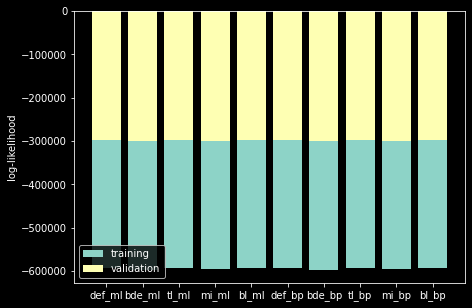

In [25]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_txt, ll_train)
ax.bar(model_txt, ll_valid)
ax.set_ylabel('log-likelihood')
ax.legend(['training', 'validation'])
# fig.show()

In [26]:
# choose the model that leads to the best loglikelihood (on the validation data)
ix = np.argmax(ll_valid)
bn = models[ix]

print(model_txt[ix])
print('-' * 7)
print(bn.edges)

def_ml
-------
[('age', 'class'), ('age', 'education-num'), ('age', 'workclass'), ('class', 'education-num'), ('class', 'capital-gain'), ('class', 'capital-loss'), ('class', 'occupation'), ('class', 'hours-per-week'), ('class', 'sex'), ('education-num', 'education'), ('education-num', 'occupation'), ('occupation', 'workclass'), ('occupation', 'hours-per-week'), ('marital-status', 'relationship'), ('marital-status', 'age'), ('marital-status', 'sex'), ('relationship', 'sex'), ('relationship', 'class'), ('relationship', 'hours-per-week'), ('relationship', 'age'), ('relationship', 'capital-gain'), ('sex', 'occupation'), ('capital-gain', 'capital-loss'), ('race', 'marital-status'), ('race', 'fnlwgt'), ('race', 'relationship'), ('native-country', 'race'), ('native-country', 'education-num'), ('native-country', 'fnlwgt')]


# Inference

The resulting DAG can be visualized.

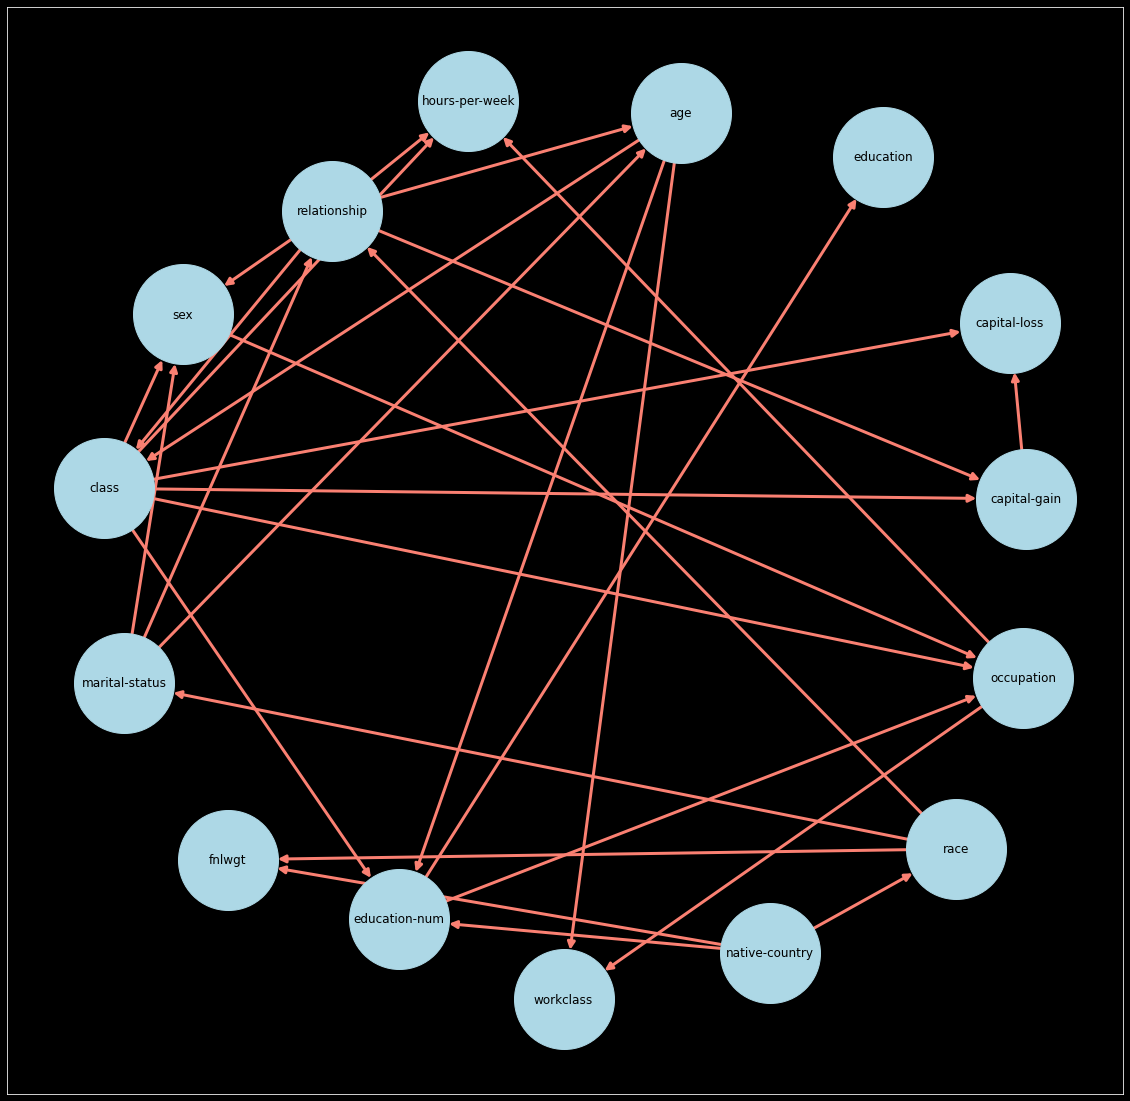

In [27]:
plt.figure(figsize=(20,20))
plt.tight_layout()
options = {
    'node_color': 'lightblue',
    'node_size': 10**4,
    'edge_color':'salmon',
    'width': 3,
    'arrowstyle': '-|>',
    'arrowsize': 15
}
# nx.draw_networkx(G[, pos, arrows, with_labels])
nx.draw_networkx(bn, **options)
# plt.show()

Some probabilities (defined in the DAG) are already kwnon. The conditional probability ditributions (CPDs) can be obtained in `pgmpy` using `get_cpds()`.

One efficient (and exact) way of performing inference is variable elimination.

In [28]:
infer = VariableElimination(bn)

Inference can be done for any variable in the network and conditioned on the values of other variables.

In [29]:
print(infer.query(['sex']))

Eliminating: race: 100%|██████████| 6/6 [00:00<00:00, 182.02it/s]

+--------------+------------+
| sex          |   phi(sex) |
+==============+============+
| sex( Female) |     0.3349 |
+--------------+------------+
| sex( Male)   |     0.6651 |
+--------------+------------+


In [30]:
evidence = {'capital-loss': 0}
print(infer.query(['capital-gain'], evidence=evidence))

Eliminating: relationship: 100%|██████████| 6/6 [00:00<00:00, 240.04it/s]

+-------------------+---------------------+
| capital-gain      |   phi(capital-gain) |
+===================+=====================+
| capital-gain(0.0) |              0.9229 |
+-------------------+---------------------+
| capital-gain(1.0) |              0.0495 |
+-------------------+---------------------+
| capital-gain(2.0) |              0.0183 |
+-------------------+---------------------+
| capital-gain(3.0) |              0.0031 |
+-------------------+---------------------+
| capital-gain(4.0) |              0.0062 |
+-------------------+---------------------+


In [31]:
evidence = {'native-country': ' China'}
print(infer.query(['race'], evidence=evidence))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------+-------------+
| race                      |   phi(race) |
+===========================+=============+
| race( Amer-Indian-Eskimo) |      0.0434 |
+---------------------------+-------------+
| race( Asian-Pac-Islander) |      0.8086 |
+---------------------------+-------------+
| race( Black)              |      0.0434 |
+---------------------------+-------------+
| race( Other)              |      0.0434 |
+---------------------------+-------------+
| race( White)              |      0.0612 |
+---------------------------+-------------+


In [32]:
evidence = {
    'class': ' >50K', 
    'relationship': ' Wife'
}
print(infer.query(['marital-status'], evidence=evidence))

Eliminating: race: 100%|██████████| 3/3 [00:00<00:00, 374.71it/s]


+----------------------------------------+-----------------------+
| marital-status                         |   phi(marital-status) |
+========================================+=======================+
| marital-status( Divorced)              |                0.0129 |
+----------------------------------------+-----------------------+
| marital-status( Married-AF-spouse)     |                0.0210 |
+----------------------------------------+-----------------------+
| marital-status( Married-civ-spouse)    |                0.9144 |
+----------------------------------------+-----------------------+
| marital-status( Married-spouse-absent) |                0.0129 |
+----------------------------------------+-----------------------+
| marital-status( Never-married)         |                0.0129 |
+----------------------------------------+-----------------------+
| marital-status( Separated)             |                0.0129 |
+----------------------------------------+--------------------

In [33]:
evidence = {
    'class': ' <=50K',
    'marital-status': ' Never-married'
}
print(infer.query(['age'], evidence=evidence))

Eliminating: race: 100%|██████████| 3/3 [00:00<00:00, 333.40it/s]

+----------+------------+
| age      |   phi(age) |
+==========+============+
| age(0.0) |     0.8132 |
+----------+------------+
| age(1.0) |     0.1519 |
+----------+------------+
| age(2.0) |     0.0348 |
+----------+------------+


In [34]:
evidence = {
    'age': 2,
    'relationship': ' Not-in-family'
}
print(infer.query(['class'], evidence=evidence))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------+--------------+
| class         |   phi(class) |
+===============+==============+
| class( <=50K) |       0.8700 |
+---------------+--------------+
| class( >50K)  |       0.1300 |
+---------------+--------------+


In [35]:
evidence = {
    'class': ' >50K', 
    'occupation': ' Prof-specialty', 
    'relationship': ' Husband'
}
print(infer.query(['hours-per-week'], evidence=evidence))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------+-----------------------+
| hours-per-week      |   phi(hours-per-week) |
+=====================+=======================+
| hours-per-week(0.0) |                0.0414 |
+---------------------+-----------------------+
| hours-per-week(1.0) |                0.4698 |
+---------------------+-----------------------+
| hours-per-week(2.0) |                0.3446 |
+---------------------+-----------------------+
| hours-per-week(3.0) |                0.1195 |
+---------------------+-----------------------+
| hours-per-week(4.0) |                0.0247 |
+---------------------+-----------------------+
